In [1]:
import pandas as pd
import numpy as np

# Esto es para que muestre todas las columnas cuando visualizamos
pd.set_option("display.max_columns", None)

# Vamos a probar 2 algoritmos muy típicos que están en la librería scikit-learn
# Regresión Logística y RadomForest

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Vamos también a probar 1 algoritmo muy típico como es xgboost (lo hemos instalado a mayores)
# scikit-learn tiene algoritmos de descenso de gradiente, pero no xgboost
# En total probaremos 3 algoritmos diferentes
# conda install -c anaconda py-xgboost
# pip install xgboost

import xgboost as xgb

# Importamos de scikit-learn lo que necesitamos para entrenar y mostrar algún resultado

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Importamos de la librería yellowbrick que hemos instalado funciones para visualization de resultados
# conda install -c districtdatalabs yellowbrick
# pip install yellowbrick

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix

# Importamos GridSearchCV y ShuffleSplit para la búsqueda de hiperpatrámetros

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# Ver importancia de las variables
from sklearn.inspection import permutation_importance

# Guardar el modelo entrenado
import pickle

# Para sacar tiempos
import time

In [2]:
df = pd.read_csv('.\\data\\TotalSemana_clean.csv').drop(['Unnamed: 0'], axis=1)
df.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,FwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label,EasyLabel,Label_category
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0,0.0
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323252,758,3,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0,0.0
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0,0.0
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0,0.0
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538461,68.000000,736.0,204,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0,0.0


In [3]:
df.shape

(2300825, 73)

In [4]:
# Divisón de los datos, 70% para entrenar

X, y = df.iloc[:,:-3],df['Label_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [5]:
# Cargamos el modelo ya del fichero para no volverlo a entrenar
with open('.\\Data\\xGboost.pickle', 'rb') as f:
    xGboost = pickle.load(f)

## Permutance feature importance

In [6]:
# Lo hacemos con 5 repeticiones

from sklearn.inspection import permutation_importance
r = permutation_importance(xGboost, X_test, y_test,
                           n_repeats=5,
                           random_state=0)

In [7]:
# Guardamos el resultado en fichero Excel
pd.DataFrame([r.importances_mean, r.importances_std, df.columns]).transpose().to_excel('.\\Data\\featurePermutationImportance5.xlsx')

In [8]:
# Lo mostramos en pantalla
for i in r.importances_mean.argsort()[::-1]:
    print(f"{df.columns[i]:<8} -- "
          f"{r.importances_mean[i]:.6f}"
          f" +/- {r.importances_std[i]:.6f}")

DestinationPort -- 0.069411 +/- 0.000160
Init_Win_bytes_forward -- 0.034242 +/- 0.000084
TotalLengthofFwdPackets -- 0.021225 +/- 0.000096
PSHFlagCount -- 0.019452 +/- 0.000034
Init_Win_bytes_backward -- 0.006634 +/- 0.000070
FwdHeaderLength -- 0.004712 +/- 0.000086
FlowIATMin -- 0.004589 +/- 0.000075
BwdHeaderLength -- 0.003237 +/- 0.000042
FwdIATMin -- 0.002325 +/- 0.000019
AveragePacketSize -- 0.001181 +/- 0.000044
min_seg_size_forward -- 0.001088 +/- 0.000030
FwdPacketLengthMax -- 0.000831 +/- 0.000014
BwdPackets/s -- 0.000360 +/- 0.000008
BwdPacketLengthMin -- 0.000315 +/- 0.000016
BwdPacketLengthStd -- 0.000301 +/- 0.000013
FlowDuration -- 0.000194 +/- 0.000008
FlowIATMean -- 0.000184 +/- 0.000017
TotalLengthofBwdPackets -- 0.000181 +/- 0.000017
PacketLengthMean -- 0.000147 +/- 0.000005
TotalFwdPackets -- 0.000142 +/- 0.000006
PacketLengthStd -- 0.000112 +/- 0.000005
Down/UpRatio -- 0.000091 +/- 0.000004
FINFlagCount -- 0.000090 +/- 0.000003
FlowPackets/s -- 0.000088 +/- 0.000009


In [13]:
# Entrenamos ya el modelo simplificado con todos los datos disponibles
# y lo guardamos para poderlo usar en la calculadora.

In [30]:
# Cogemos las 5 variables más significativas para ver cómo funciona el modelo simplificado

# var10 = ['DestinationPort','Init_Win_bytes_forward','TotalLengthofFwdPackets','PSHFlagCount','Init_Win_bytes_backward','FwdHeaderLength','FlowIATMin','BwdHeaderLength','FwdIATMin','AveragePacketSize']
var5 = ['DestinationPort','Init_Win_bytes_forward','TotalLengthofFwdPackets','PSHFlagCount','Init_Win_bytes_backward']

# Divisón de los datos para ya solo coger esas 10 variables
X, y = df[var5],df['Label_category']

In [31]:
# Entrenamos el modelo

xGboost = xgb.XGBClassifier(max_depth = 6, n_estimators = 100)
xGboost.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [32]:
# Guardamos el modelo 
filename = '.\\app-heroku\\model_app\\xGboost.pickle'
pickle.dump(xGboost, open(filename, 'wb'))

## Resultados con 5 variables

In [5]:
# Divisón de los datos, 70% para entrenar
var5 = ['DestinationPort','Init_Win_bytes_forward','TotalLengthofFwdPackets','PSHFlagCount','Init_Win_bytes_backward']

X, y = df[var5],df['Label_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [6]:
xGboost = xgb.XGBClassifier(max_depth = 6, n_estimators = 100)
xGboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [7]:
score = xGboost.score(X_test, y_test)
score

0.9946265690012865

C:\Users\70910624Z\Anaconda3\envs\mrseg\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


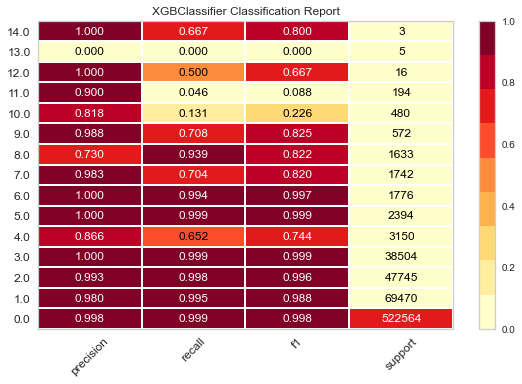

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [8]:
visualizer = ClassificationReport(xGboost, support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

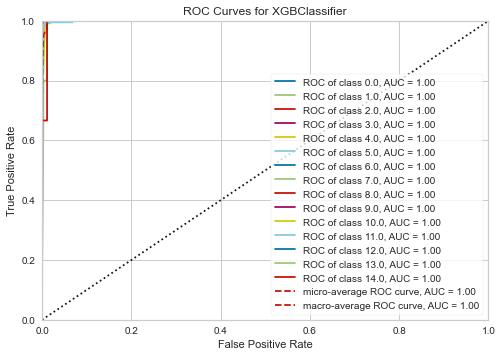

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [9]:
visualizer = ROCAUC(xGboost)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

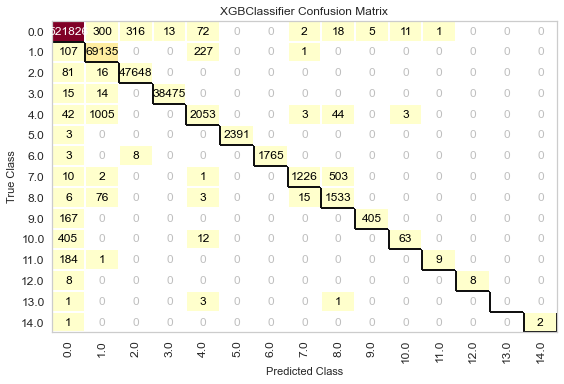

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [10]:
cm = ConfusionMatrix(xGboost)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()